In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({"figure.figsize": (20, 10), "figure.dpi": 120})

from src.ETL import *
from src.dashboard import get_line_fig, add_slider, plot_forecast

from darts.models import NaiveSeasonal, LinearRegressionModel, VARIMA
from darts import TimeSeries, concatenate
from darts.metrics import rmse, mase, mape, r2_score
from darts.utils.statistics import (
    plot_acf,
    plot_pacf,
    plot_residuals_analysis,
    plot_hist,
)
from darts.dataprocessing.transformers import Mapper, Diff


# ROOT_PATH = "data Toronto rents 2025Q1"
ROOT_PATH = "data"

## Covariates engineering

<Axes: xlabel='Date'>

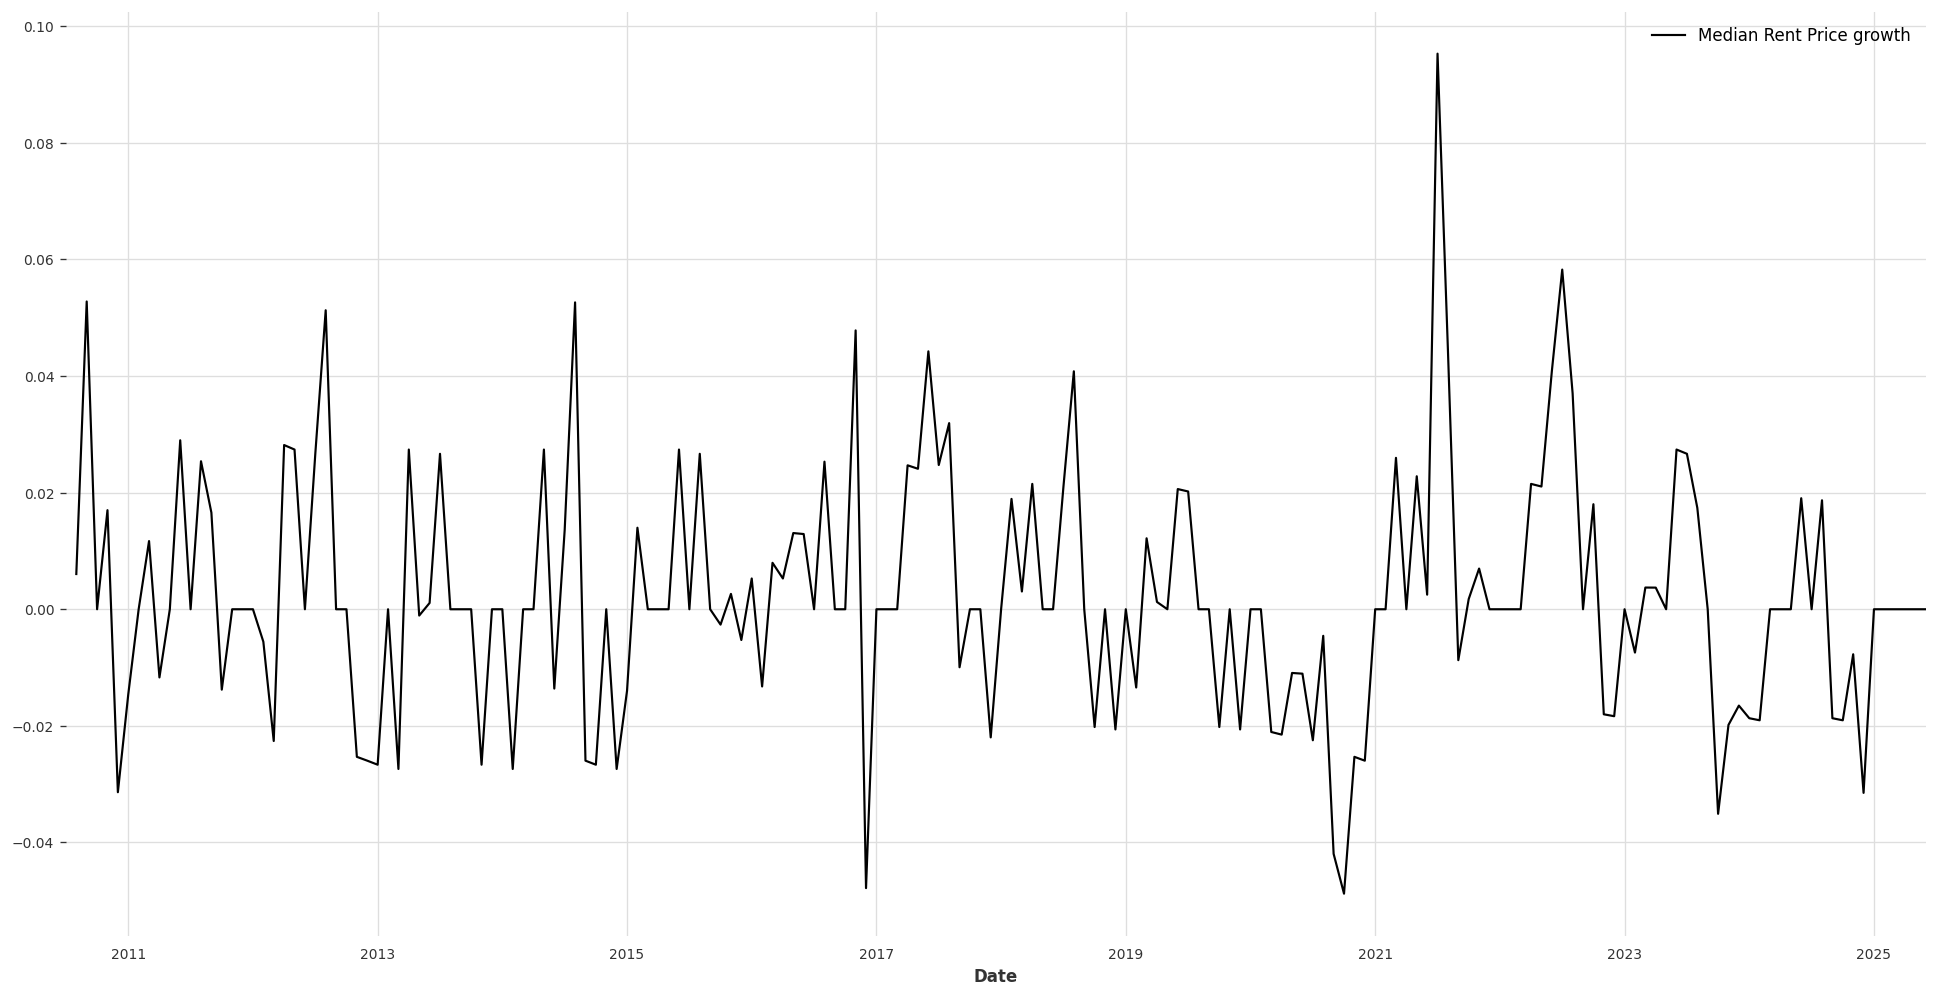

In [110]:
cpi = etl_pipeline(
    extract_data_from_StatsCanada_API,
    {"vector_id": 41691954, "latest_n": 600, "new_name": "CPI"},
    num_lags=0,
)
df1 = etl_pipeline(
    extract_data_from_HS_json,
    {
        "file_path": f"{ROOT_PATH}/rent.json",
        "cols": ["price_rent"],
        "new_names": ["Median Rent Price"],
    },
    transform_dict={"Median Rent Price": growth(1)},
    num_lags=13,
    lagged_cols=["Median Rent Price growth"],
)
df1 = df1  # [:-1]

target = "Median Rent Price growth"
target2 = "Median Rent Price"
df1[[target]].plot()
# df1[["Rent_real", "Rent"]].plot()

In [112]:
df_cov = df1.join(
    etl_pipeline(
        extract_data_from_StatsCanada_CSV,
        {
            "file_path": f"{ROOT_PATH}/14100383.csv",
            "in_col": "Labour force characteristics",
            "out_cols": [
                "Participation rate",
                "Employment rate",
                "Unemployment rate",
                "Population",
                "Labour force",
            ],
            "filters": {
                "GEO": "Toronto, Ontario",
                "Data type": "Seasonally adjusted",
                "Statistics": "Estimate",
            },
        },
        transform_dict={
            "Unemployment rate": [growth(1), growth(12), diff(1), diff(12)],
            "Participation rate": [diff(1), diff(12)],
            "Population": [growth(1), growth(12)],
            "Labour force": [growth(12)],
        },
    )
)

# df_cov = df_cov.join(etl_pipeline(extract_data_from_CREA, file_path = f'{ROOT_PATH}/MLS_HPI/Seasonally Adjusted_June_2024.xlsx', sheet_name = 'GREATER_TORONTO',
#                 in_col = "Apartment_Benchmark_SA", new_names = ["HPI"]),
#                 transform_dict = {"HPI": [growth(1), compose(growth(1), to_real(cpi))]}))

# df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada_CSV, {file_path = f'{ROOT_PATH}/1410022201_databaseLoadingData.csv',
#                             in_col = "Estimate",
#                             out_cols = ["Employment for all employees", "Average weekly earnings including overtime for all employees",
#                                         "Employment for salaried employees", "Average weekly earnings including overtime for salaried employees"],
#                             new_names = ["Employment", "Avg weekly earnings", "Employment salaried", "Avg weekly earnings salaried"]},
#                             transform_dict = {"Employment": [growth(1), growth(12)],
#                                               "Avg weekly earnings": [growth(1), growth(12)],}
#                             ))
df_cov = df_cov.join(
    etl_pipeline(
        extract_data_from_StatsCanada_CSV,
        {
            "file_path": f"{ROOT_PATH}/34100145.csv",
            "in_col": None,
            "out_cols": ["Mortgage rate 5y"],
        },
        transform_dict={"Mortgage rate 5y": [diff(1), diff(12), growth(1), growth(12)]},
    )
)

df_cov = df_cov.join(
    etl_pipeline(
        extract_data_from_StatsCanada_CSV,
        {
            "file_path": f"{ROOT_PATH}/18100205.csv",
            "in_col": "New housing price indexes",
            "out_cols": ["Total (house and land)", "House only", "Land only"],
            "new_names": ["NHPI", "House only", "Land only"],
            "filters": {"GEO": "Toronto, Ontario"},
        },
        transform_dict={
            "NHPI": [growth(1), compose(growth(1), to_real(cpi))],
            "House only": [growth(1), compose(growth(1), to_real(cpi))],
            "Land only": [growth(1), compose(growth(1), to_real(cpi))],
        },
    )
)


df_cov = df_cov.join(
    etl_pipeline(
        extract_data_from_HS_json,
        {
            "file_path": f"{ROOT_PATH}/rent.json",
            "cols": ["rent_count", "rent_listing_count"],
            "new_names": ["Total Leased", "New Listings"],
        },
        transform_dict={
            "Total Leased": [growth(1), growth(12)],
            "New Listings": [growth(1), growth(12)],
        },
    )
)

df_cov = df_cov.join(cpi)
df_cov["CPI growth"] = df_cov["CPI"].pct_change()

df_cov["LNLR"] = df_cov["Total Leased"] / df_cov["New Listings"]
# df_cov["LNLR_growth"] = df_cov["LNLR"].pct_change()
df_cov["LNLR_growth12"] = df_cov["LNLR"].pct_change(12)

df_cov = make_lags(df_cov, 12, ["LNLR", "LNLR_growth12"])

df_cov = df_cov.ffill().bfill()
df_cov = df_cov[sorted(df_cov.columns)]

# df_cov

corr_lag = df_cov.corr()[target][df_cov.corr()[target].abs() > 0.2].sort_values()
df_cov.corr()

Transformation is not successful!


/var/folders/yv/s556grcd04xf99g1bgg7tych0000gn/T/ipykernel_95634/2377085685.py:88: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



,CPI,CPI growth,Employment rate,Employment rate lag 1,Employment rate lag 2,Employment rate lag 3,Employment rate lag 4,Employment rate lag 5,House only,House only lag 1,...,Unemployment rate growth12 lag 1,Unemployment rate growth12 lag 2,Unemployment rate growth12 lag 3,Unemployment rate growth12 lag 4,Unemployment rate growth12 lag 5,Unemployment rate lag 1,Unemployment rate lag 2,Unemployment rate lag 3,Unemployment rate lag 4,Unemployment rate lag 5
CPI,1.000000,0.309736,-0.107014,-0.104419,-0.074711,-0.055167,-0.039155,-0.014256,0.828413,0.835138,...,0.227138,0.137389,0.144510,0.173375,0.115889,-0.065021,-0.170626,-0.170160,-0.126387,-0.201926
CPI growth,0.309736,1.000000,0.134359,0.065741,0.049615,0.046945,0.012818,0.095949,0.280325,0.280255,...,-0.036104,-0.101976,-0.048391,-0.068179,-0.118785,-0.067596,-0.109666,-0.079365,-0.100300,-0.137983
Employment rate,-0.107014,0.134359,1.000000,0.879722,0.666987,0.461005,0.300957,0.190146,-0.005851,-0.005866,...,-0.625926,-0.541518,-0.473636,-0.431754,-0.394810,-0.655318,-0.460164,-0.309621,-0.214106,-0.130185
Employment rate lag 1,-0.104419,0.065741,0.879722,1.000000,0.878657,0.665136,0.459253,0.297316,-0.009086,-0.008237,...,-0.694670,-0.617137,-0.544444,-0.481023,-0.424630,-0.805408,-0.631729,-0.460083,-0.324297,-0.194539
Employment rate lag 2,-0.074711,0.049615,0.666987,0.878657,1.000000,0.877879,0.662800,0.454528,0.000005,0.003367,...,-0.655558,-0.684749,-0.619853,-0.545755,-0.469525,-0.798795,-0.788306,-0.638797,-0.475317,-0.306853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Unemployment rate lag 1,-0.065021,-0.067596,-0.655318,-0.805408,-0.798795,-0.710288,-0.598958,-0.493355,-0.249482,-0.255173,...,0.667680,0.614983,0.570563,0.532032,0.490150,1.000000,0.890850,0.781326,0.685436,0.579513
Unemployment rate lag 2,-0.170626,-0.109666,-0.460164,-0.631729,-0.788306,-0.785218,-0.696314,-0.587027,-0.291104,-0.300823,...,0.535306,0.649193,0.604855,0.543234,0.507282,0.890850,1.000000,0.908106,0.786456,0.681733
Unemployment rate lag 3,-0.170160,-0.079365,-0.309621,-0.460083,-0.638797,-0.793151,-0.788275,-0.700855,-0.285417,-0.295730,...,0.421404,0.554686,0.648952,0.596896,0.557769,0.781326,0.908106,1.000000,0.902864,0.796966
Unemployment rate lag 4,-0.126387,-0.100300,-0.214106,-0.324297,-0.475317,-0.650879,-0.801976,-0.796051,-0.257895,-0.266906,...,0.322148,0.439377,0.563418,0.658073,0.618733,0.685436,0.786456,0.902864,1.000000,0.903888


In [4]:
plot_list = ["Unemployment rate"]  # [col for col in df_cov.columns if "lag" not in col]
for i in plot_list:
    get_line_fig(df_cov, i, target).show()
    add_slider(df_cov, i, target).show()

In [155]:
print(corr_lag.to_string())

New Listings growth12              -0.353140
Unemployment rate diff12           -0.346979
Unemployment rate growth12         -0.340550
New Listings growth12 lag 1        -0.337703
Unemployment rate diff12 lag 2     -0.327244
Unemployment rate diff12 lag 1     -0.326874
Unemployment rate growth12 lag 1   -0.322092
Unemployment rate growth12 lag 2   -0.303612
New Listings growth12 lag 2        -0.279015
Unemployment rate diff lag 5       -0.277560
Unemployment rate diff12 lag 3     -0.277206
Unemployment rate growth lag 5     -0.261801
Unemployment rate growth12 lag 3   -0.257629
Unemployment rate diff12 lag 4     -0.244461
Unemployment rate growth12 lag 4   -0.232168
New Listings growth12 lag 3        -0.201905
Participation rate diff12 lag 2     0.205034
Median Rent Price growth lag 2      0.212948
NHPI growth lag 3                   0.220612
Total Leased                        0.225596
Participation rate diff12 lag 3     0.239512
Total Leased growth lag 1           0.242927
LNLR_growt

## Forecasting and Backtesting utils

In [114]:
def eval_results(
    y, f, model, metrics, inverse_transform=False, last_points_only=False, title=" "
):

    if inverse_transform:
        to_exp = Mapper(lambda x: np.exp(x))
        if not isinstance(f, list):
            f = (
                to_exp.transform(f.cumsum())
                * y[y[: f.time_index[0]].time_index[-2]].last_value()
            )
            # f = TimeSeries.from_dataframe(inv_growth(f.pd_dataframe(), y.last_value()))

        else:
            for i in range(len(f)):
                f[i] = (
                    to_exp.transform(f[i].cumsum())
                    * y[y[: f[i].time_index[0]].time_index[-2]].last_value()
                )

    b = model.backtest(
        y, historical_forecasts=f, last_points_only=last_points_only, metric=metrics
    )

    print("------------" + title + "------------")
    for i, metric in enumerate(metrics):
        print(metric.__name__ + ": %.4f" % b[i])

    figure = plt.figure()
    y.plot()

    if not isinstance(f, list):
        f.plot()
    else:
        for i, s in enumerate(f):
            s.plot(label=("Backtest" if i == 0 else "_nolegend_"), color="blue")

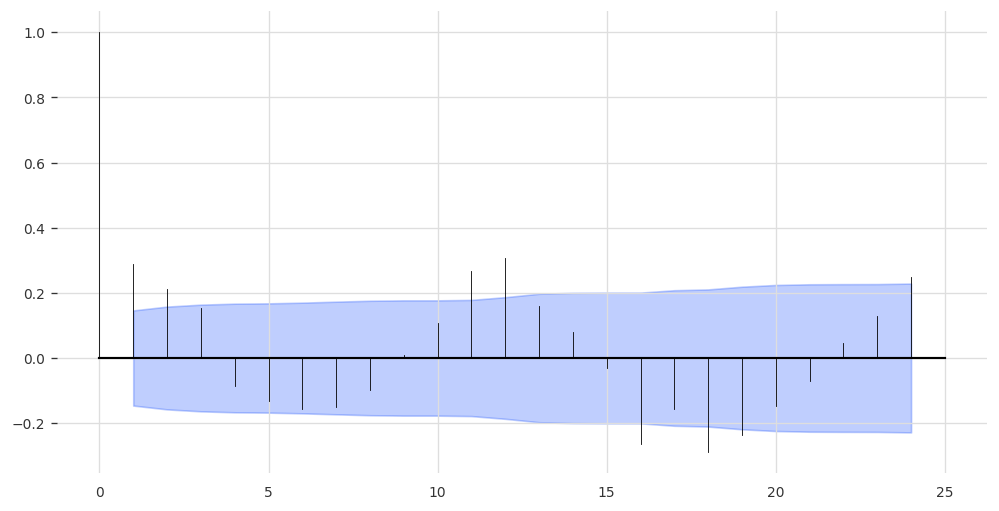

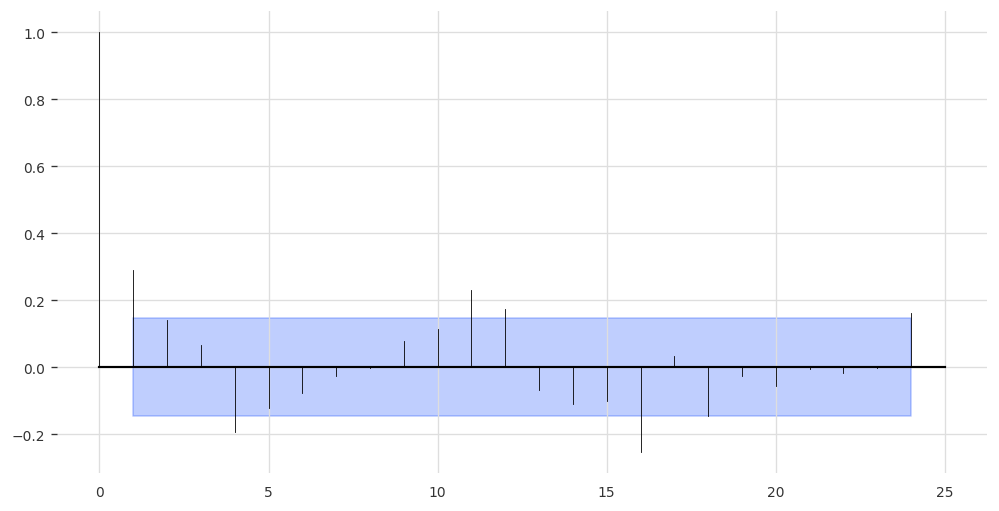

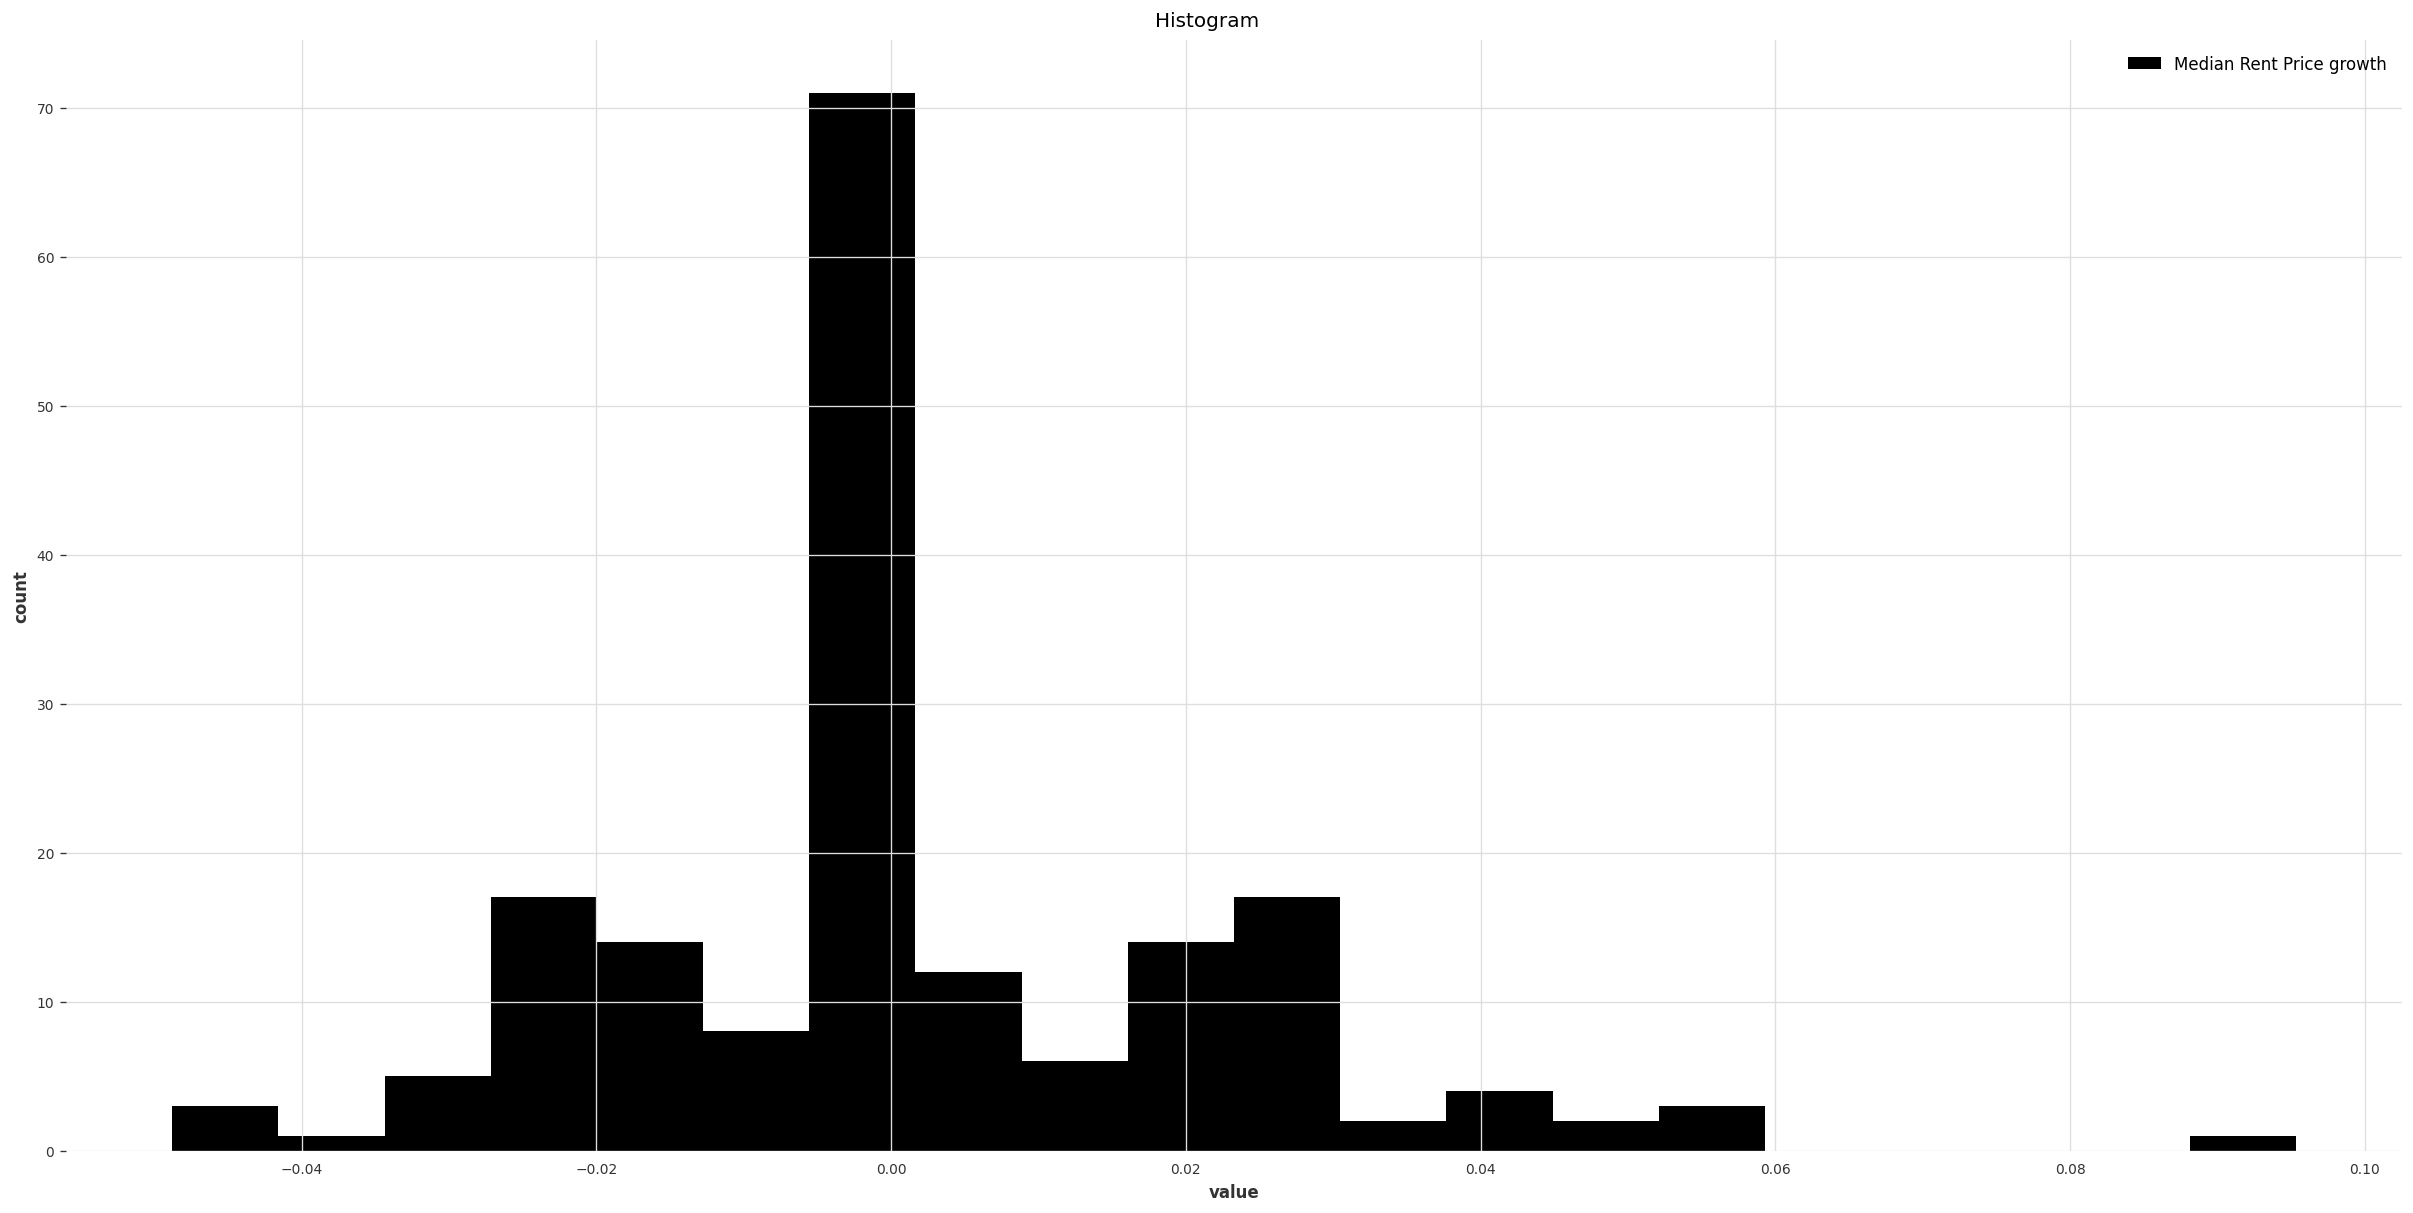

In [115]:
test_split_time = pd.Timestamp("20200925")
features = [
    "Unemployment rate diff",
    "NHPI growth",
    "LNLR",
]

y = TimeSeries.from_dataframe(df_cov, value_cols=target)
y_train, y_test = y.split_before(test_split_time)

y1 = TimeSeries.from_dataframe(df_cov, value_cols="Median Rent Price")

cov = TimeSeries.from_dataframe(df_cov, value_cols=features)
plot_acf(y)
plot_pacf(y)
plot_hist(y, bins=20)

## Linear Regression

------------Train up to 2020-09-25 00:00:00------------
rmse: 0.0167
mase: 0.5050
r2_score: 0.3506
------------Train up to 2020-09-25 00:00:00------------
rmse: 179.4934
mase: 5.2447
mape: 6.0323
r2_score: 0.6950
------------Backtest------------
rmse: 0.0168
mase: 0.6385
------------Backtest------------
rmse: 103.1163
mase: 3.1736
mape: 3.7360
------------ ------------
rmse: 0.0218
mase: 0.8668
------------ ------------
rmse: 232.7391
mase: 6.9847
mape: 8.1782


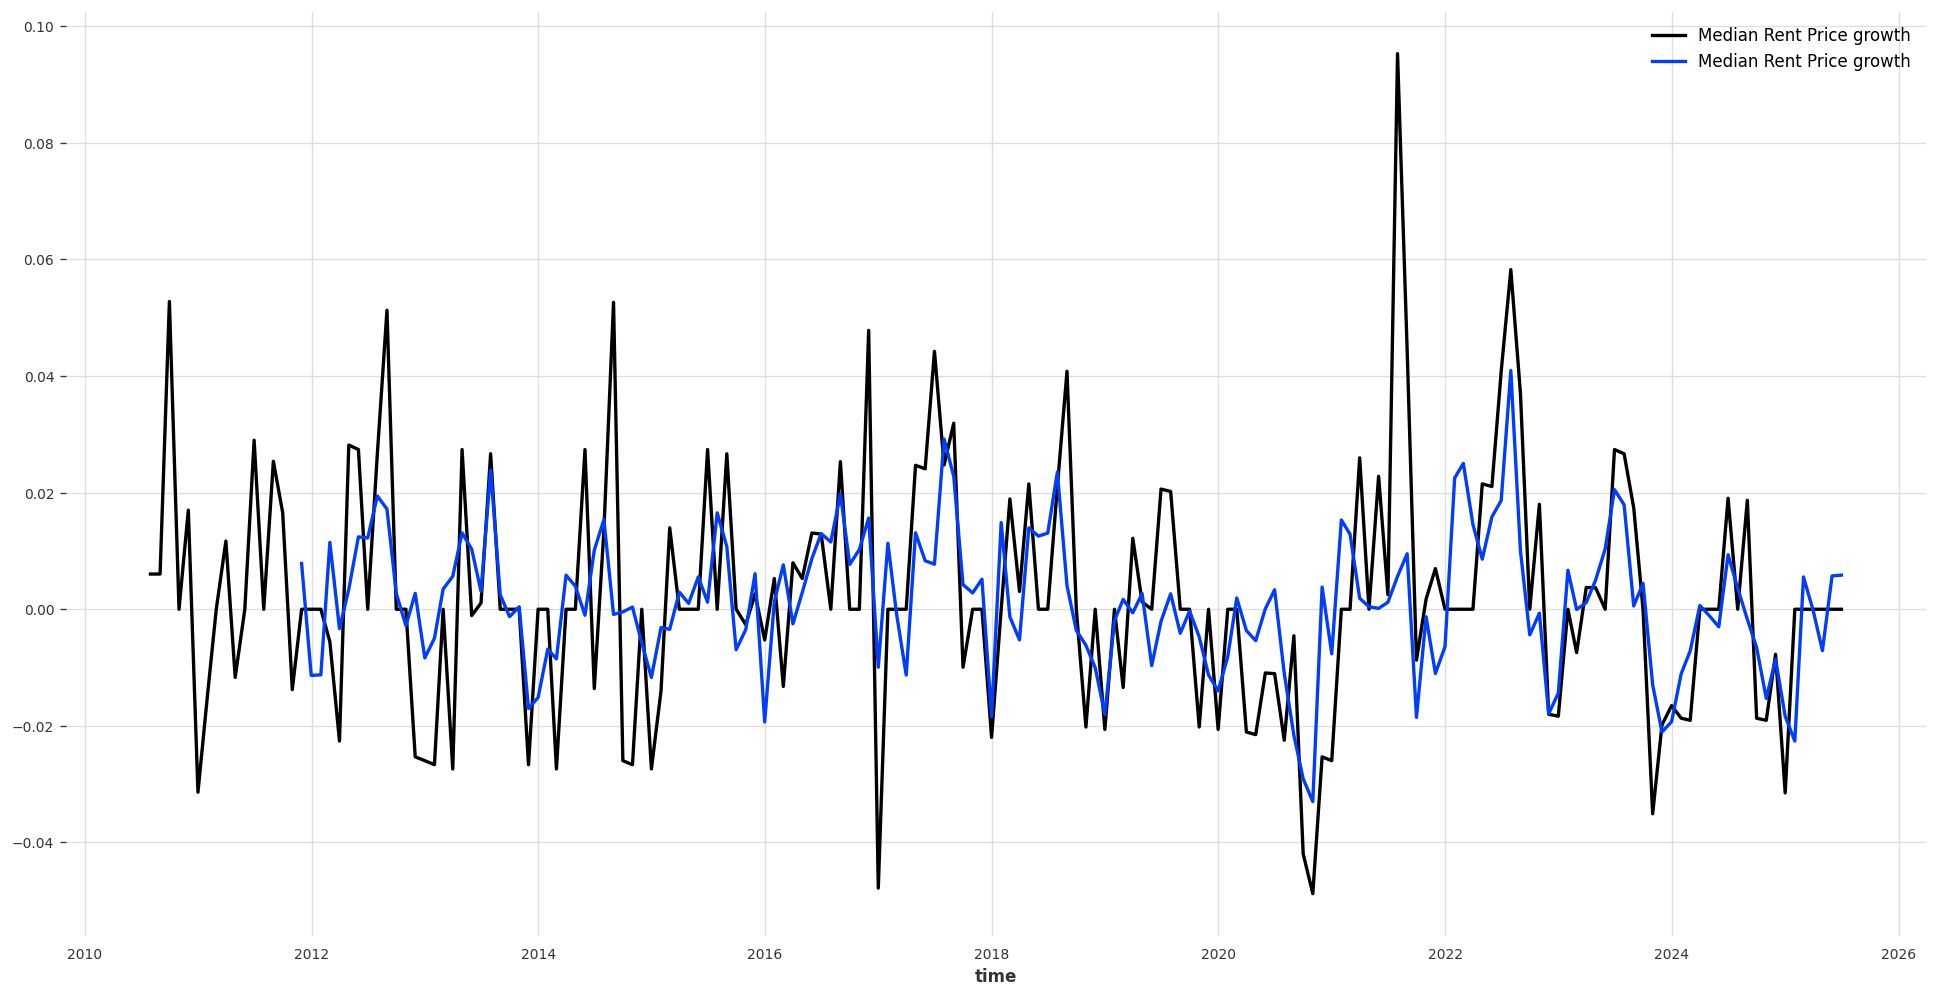

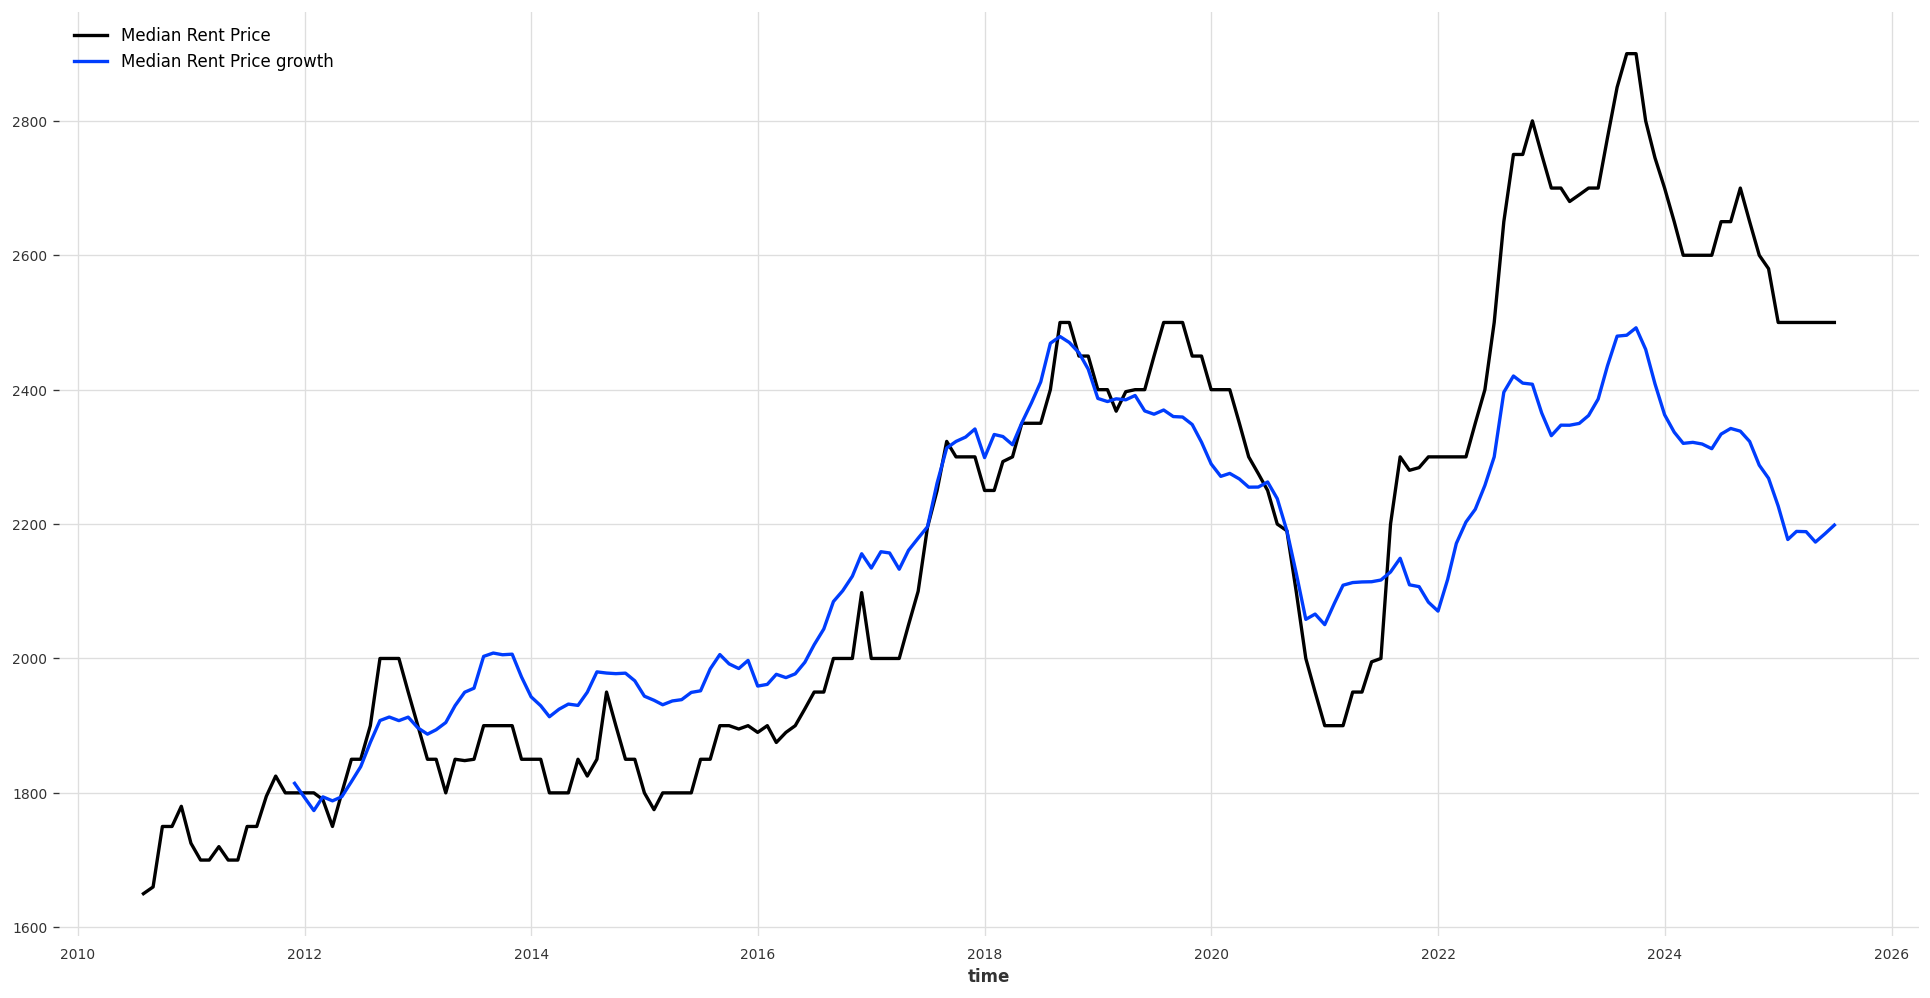

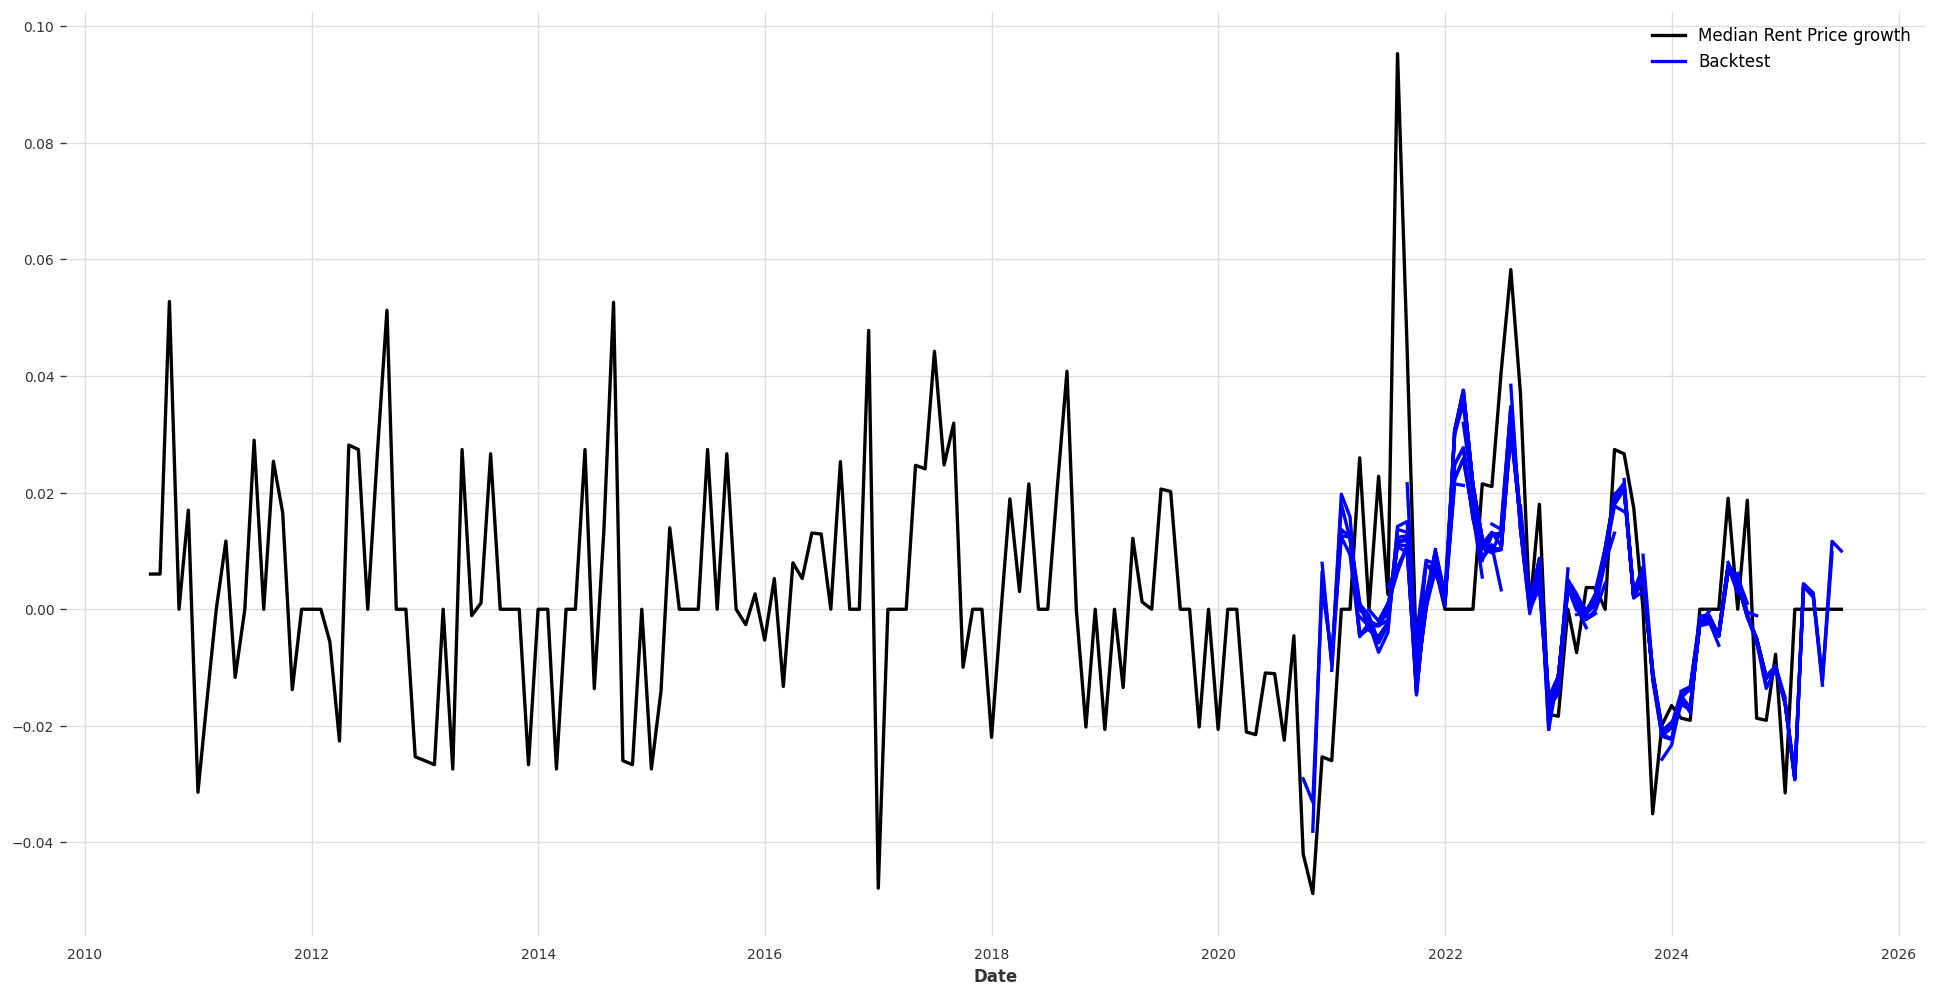

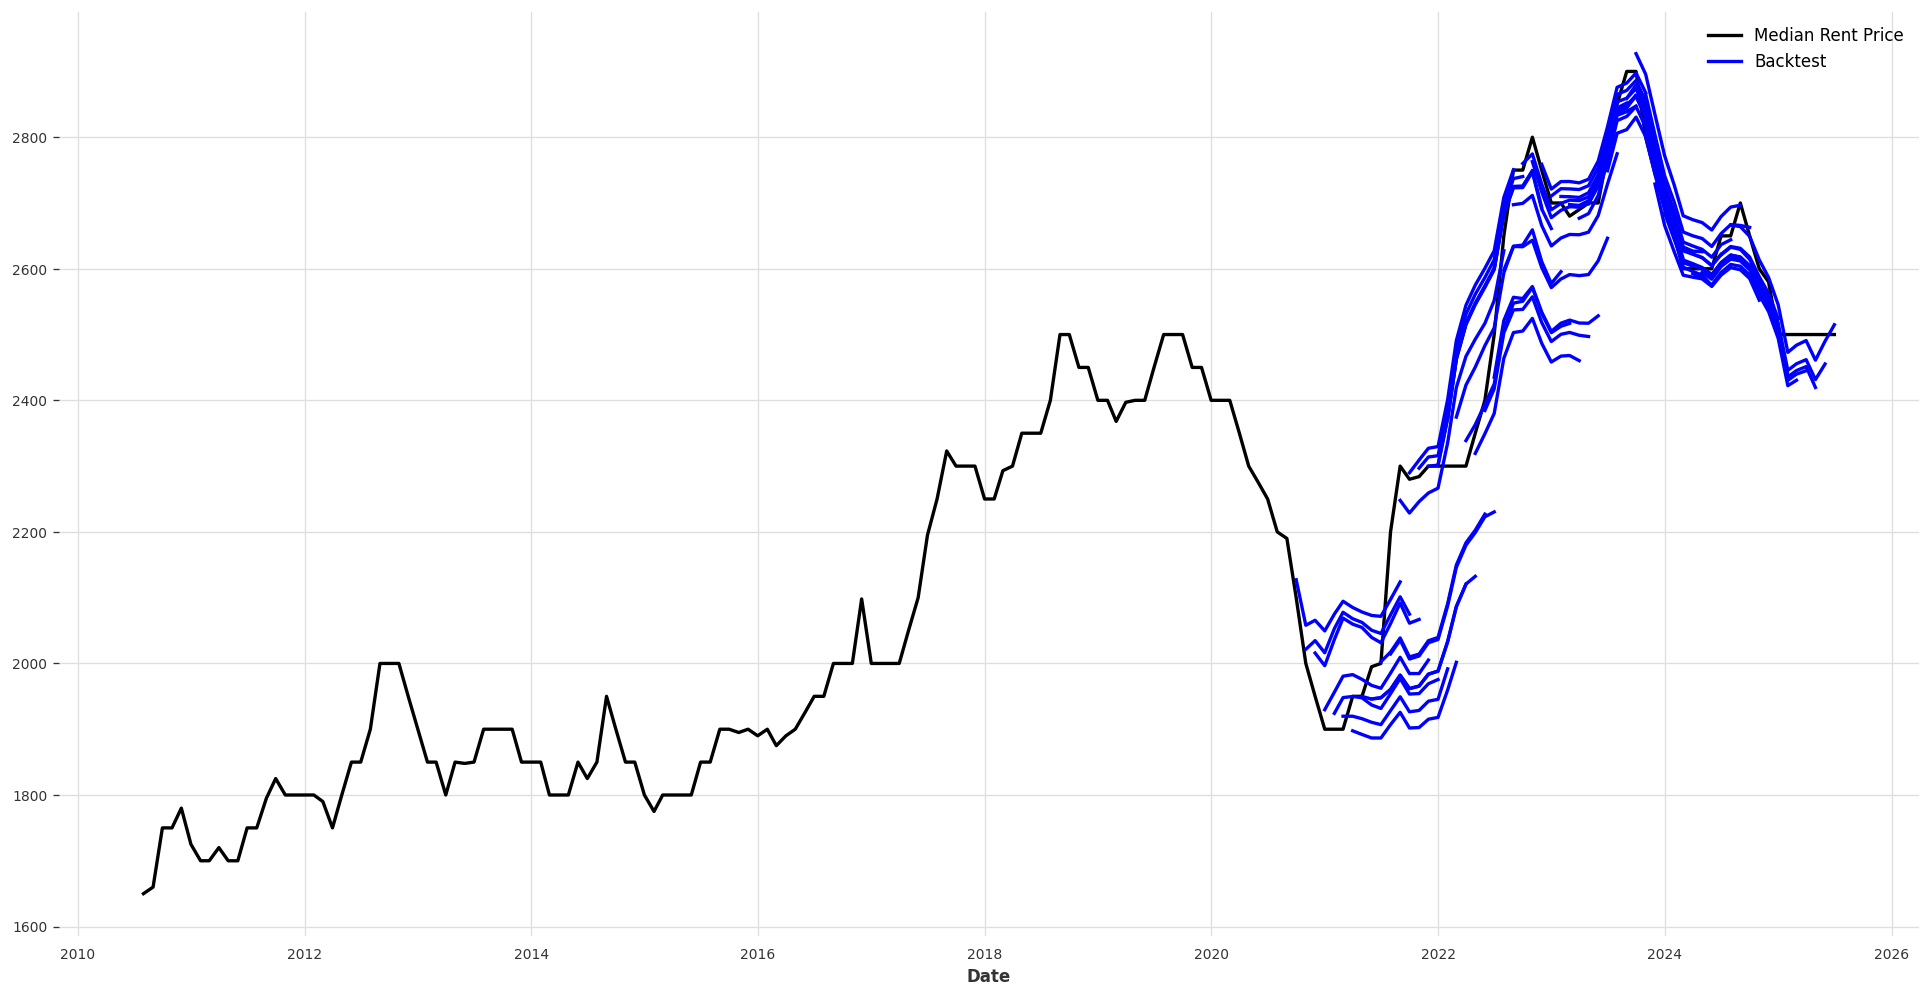

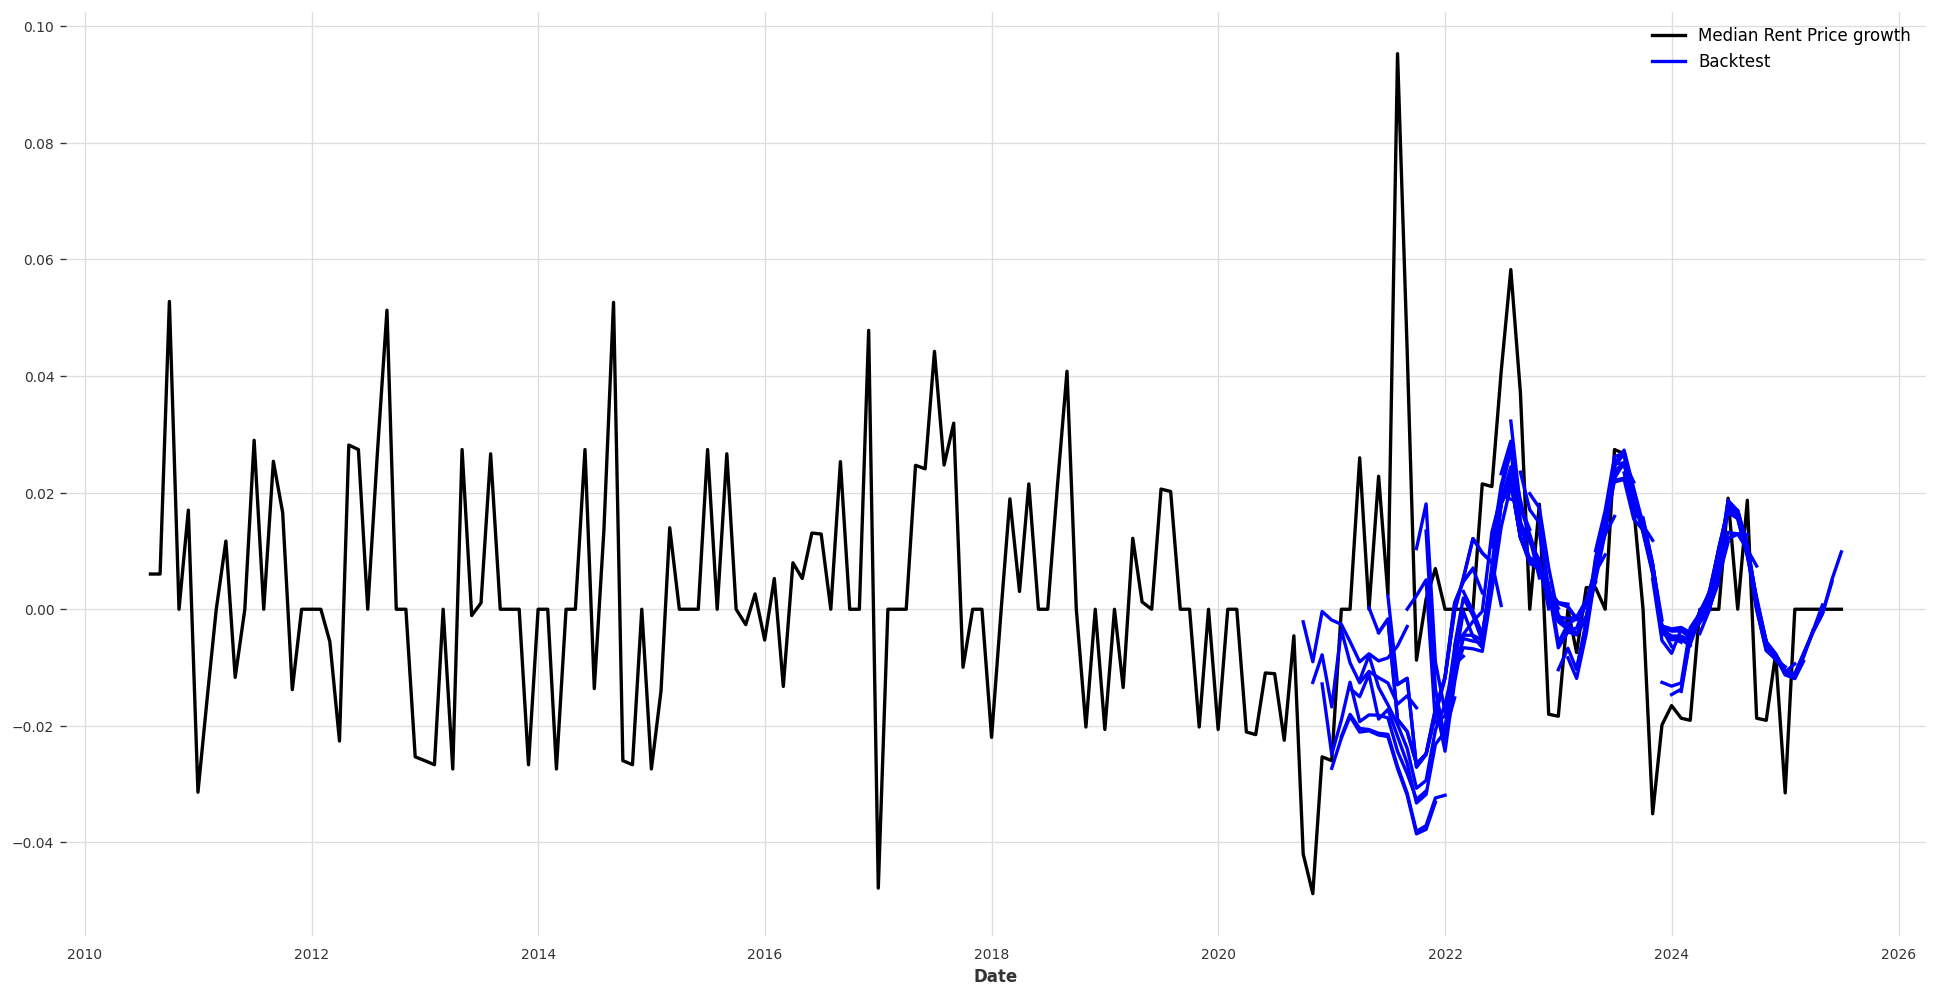

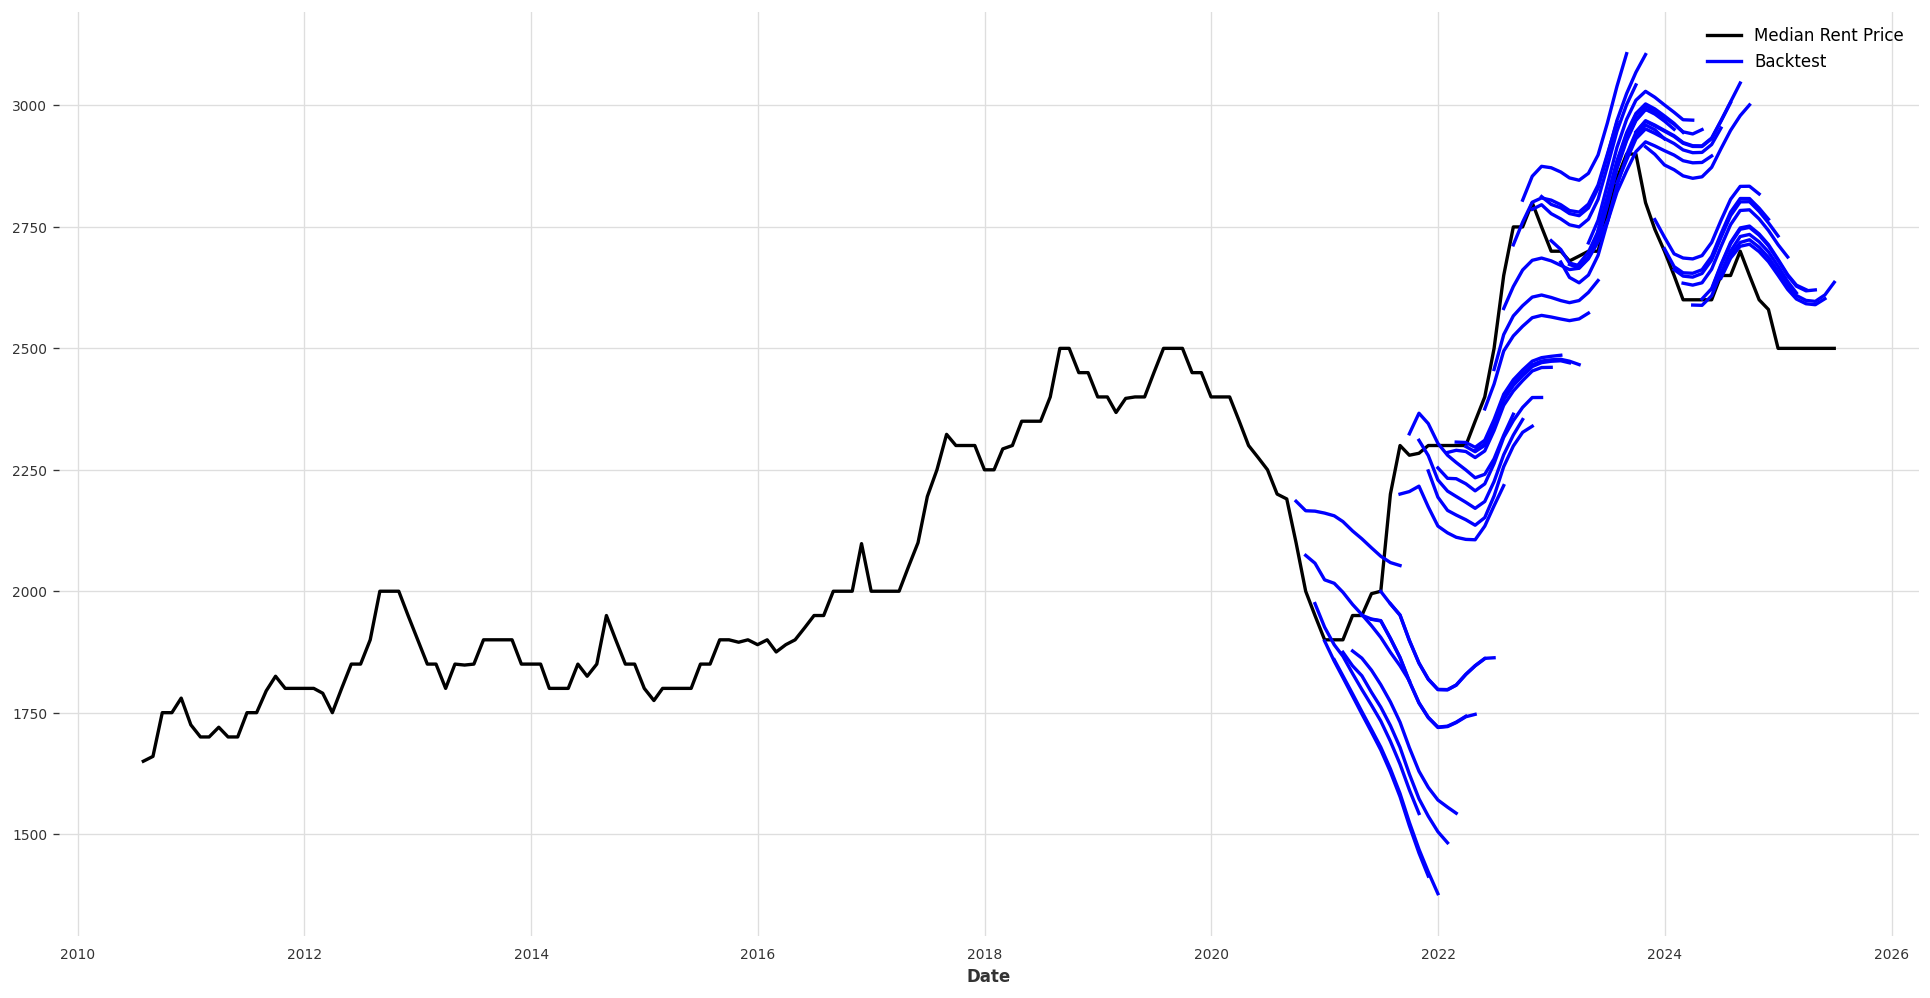

In [116]:
LR = LinearRegressionModel(
    lags=[-1, -4, -11, -12, -16],  # [-1,-12],
    lags_future_covariates={
        "Unemployment rate diff": [-5],
        "NHPI growth": [-3, -15],
        "LNLR": [-3],
    },  # Unemployment rate diff
    output_chunk_length=1,
    # likelihood='quantile',
    # quantile=0.5,
    # alpha=0
)
LR.fit(y_train, future_covariates=cov)

f = LR.historical_forecasts(
    y,
    future_covariates=cov,
    start=None,
    forecast_horizon=1,
    stride=1,
    last_points_only=True,
    retrain=False,
    overlap_end=False,
    verbose=False,
)

eval_results(
    y,
    f,
    LR,
    [rmse, mase, r2_score],
    last_points_only=True,
    title="Train up to " + str(test_split_time),
)
eval_results(
    y1,
    f,
    LR,
    [rmse, mase, mape, r2_score],
    inverse_transform=True,
    last_points_only=True,
    title="Train up to " + str(test_split_time),
)

horizon = 12
b = LR.historical_forecasts(
    y,
    future_covariates=cov,
    start=test_split_time,
    forecast_horizon=horizon,
    stride=1,
    last_points_only=False,
    retrain=True,
    overlap_end=False,
    verbose=False,
    enable_optimization=False,
)

eval_results(y, b, LR, [rmse, mase], title="Backtest")
eval_results(y1, b, LR, [rmse, mase, mape], inverse_transform=True, title="Backtest")
Naive = LinearRegressionModel(
    lags=12,  # [-1,-12],
    lags_future_covariates=None,
    output_chunk_length=1,
)
# Naive = NaiveSeasonal(12)
b = Naive.historical_forecasts(
    y,
    start=test_split_time,
    forecast_horizon=horizon,
    stride=1,
    last_points_only=False,
    retrain=True,
    overlap_end=False,
    verbose=False,
    enable_optimization=False,
)
eval_results(y, b, Naive, [rmse, mase])
eval_results(y1, b, Naive, [rmse, mase, mape], inverse_transform=True)

## Backtesting vs Benchmark

In [ ]:
def eval_results(
    y, f, model, metrics, inverse_transform=False, last_points_only=False, title=" "
):
    b = model.backtest(
        y,
        historical_forecasts=f,
        last_points_only=last_points_only,
        metric=metrics,
        metric_kwargs={"component_reduction": None},
    )
    # print(f)
    print(b)
    print("------------" + title + "------------")
    for i, metric in enumerate(metrics):
        print(metric.__name__ + ": %.4f" % b[0][i])

    to_exp = Mapper(lambda x: np.exp(x))
    if inverse_transform:
        z = y[target2]
        l = []
        for i in range(len(f)):
            l.append(
                to_exp.transform(f[i][target].cumsum())
                * z[z[: f[i][target].time_index[0]].time_index[-2]].last_value()
            )
        plt.figure()
        z.plot(color="black")

        for i, s in enumerate(l):
            s.plot(label=("Backtest" if i == 0 else "_nolegend_"), color="blue")

        return

    figure = plt.figure()
    y[target].plot()

    if not isinstance(f, list):
        f[target].plot()
    else:
        for i, s in enumerate(f):
            s[target].plot(label=("Backtest" if i == 0 else "_nolegend_"), color="blue")

/Users/andreypak/opt/miniconda3/envs/rent_app/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:373: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/andreypak/opt/miniconda3/envs/rent_app/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[[0.01746159 0.62171504 0.28054666]
 [1.16807244 1.30961863 0.77657285]
 [0.10722595 0.84907698 0.41328524]]
------------Train up to 2020-09-25 00:00:00------------
rmse: 0.0175
mase: 0.6217
r2_score: 0.2805


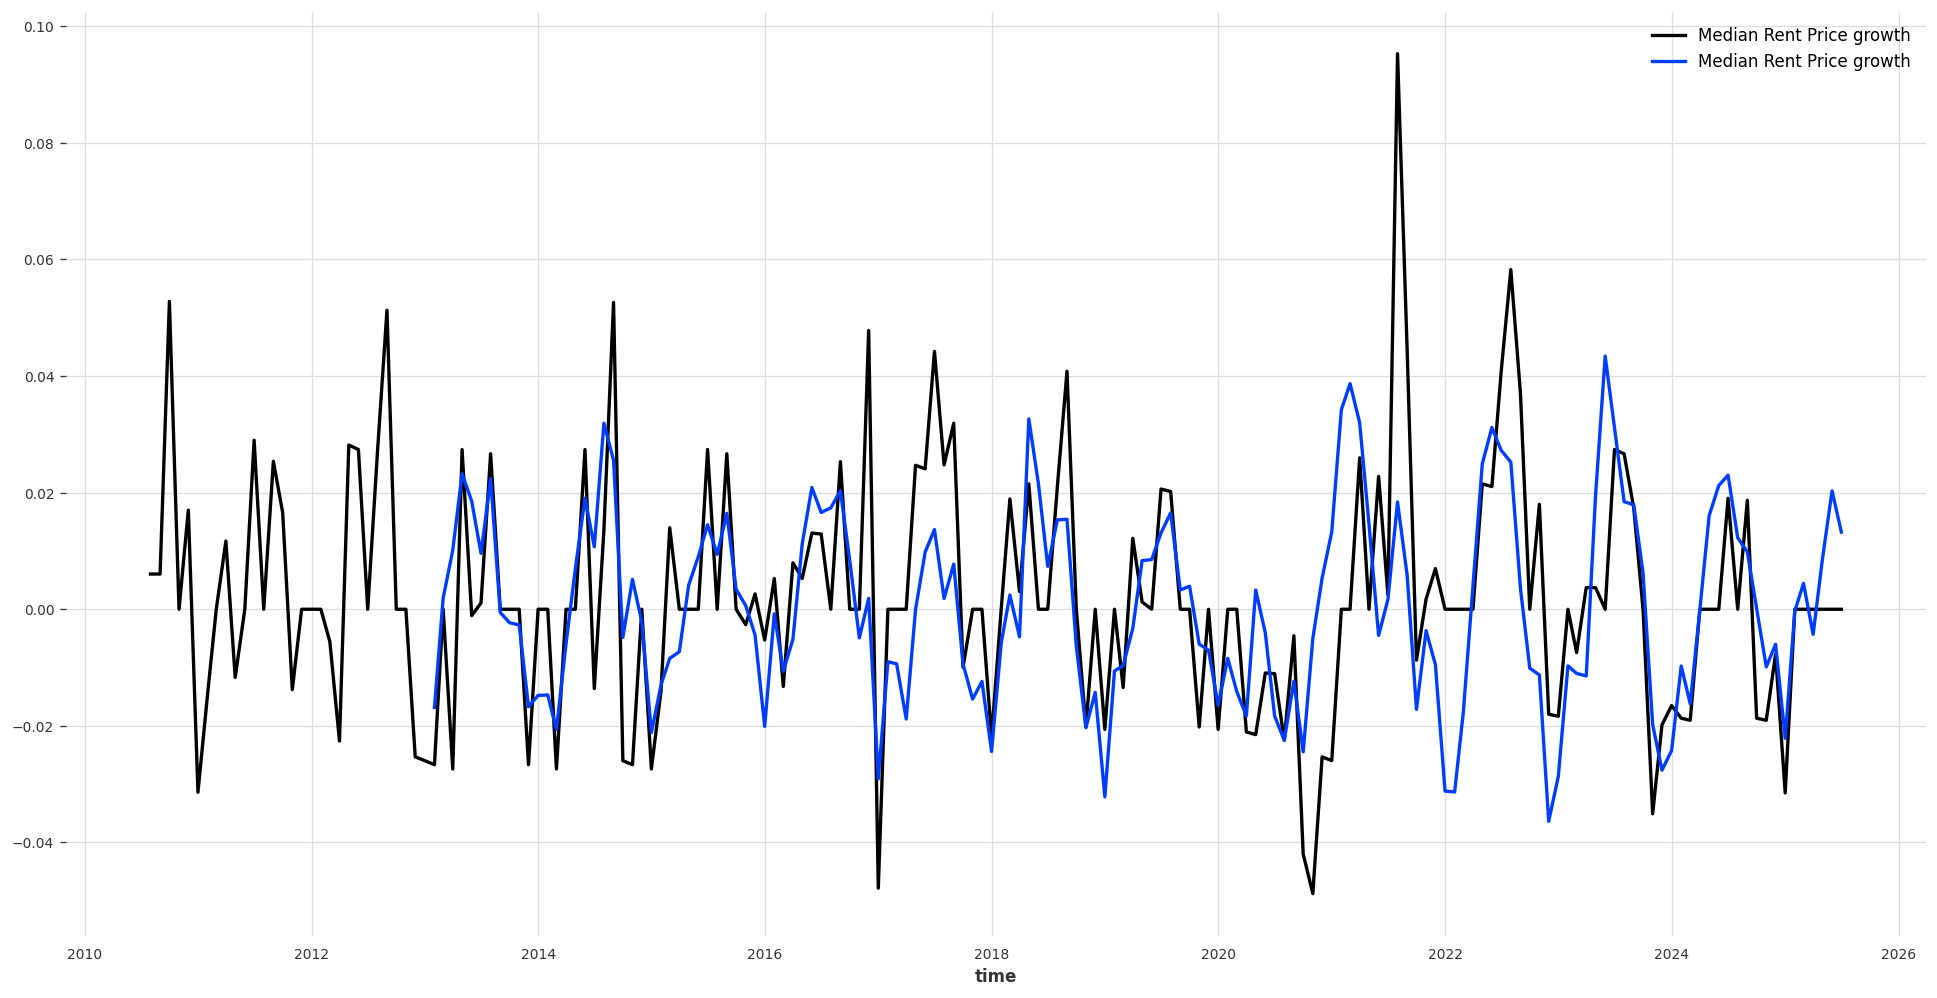

In [ ]:
features = [
    "Unemployment rate diff12",
    # "New Listings growth12",
    "NHPI growth lag 3",
    "LNLR",
]
y = TimeSeries.from_dataframe(df_cov, value_cols=[target] + features)
y_train, y_test = y.split_before(test_split_time)
y1 = TimeSeries.from_dataframe(df_cov, value_cols=[target2] + features)

# y1 = TimeSeries.from_dataframe(df_cov, value_cols=target2)

# cov = TimeSeries.from_dataframe(df_cov, value_cols=features)

VAR = VARIMA(p=16)
VAR.fit(y_train)

f = VAR.historical_forecasts(
    y,
    # future_covariates=cov,
    start=None,
    forecast_horizon=1,
    stride=1,
    last_points_only=True,
    retrain=False,
    overlap_end=False,
    verbose=False,
)
# f[target].plot(label="Backtest", color="blue")
# y[target].plot()
eval_results(
    y,
    f,
    VAR,
    [rmse, mase, r2_score],
    last_points_only=True,
    title="Train up to " + str(test_split_time),
)

[[0.02204184 0.88650039]
 [2.37015721 3.02162817]
 [0.16734705 1.78157656]]
------------Backtest------------
rmse: 0.0220
mase: 0.8865
[[2.52792174e+03 8.62308870e+01]
 [2.37015721e+00 3.02162817e+00]
 [1.67347051e-01 1.78157656e+00]]
------------Backtest------------
rmse: 2527.9217
mase: 86.2309


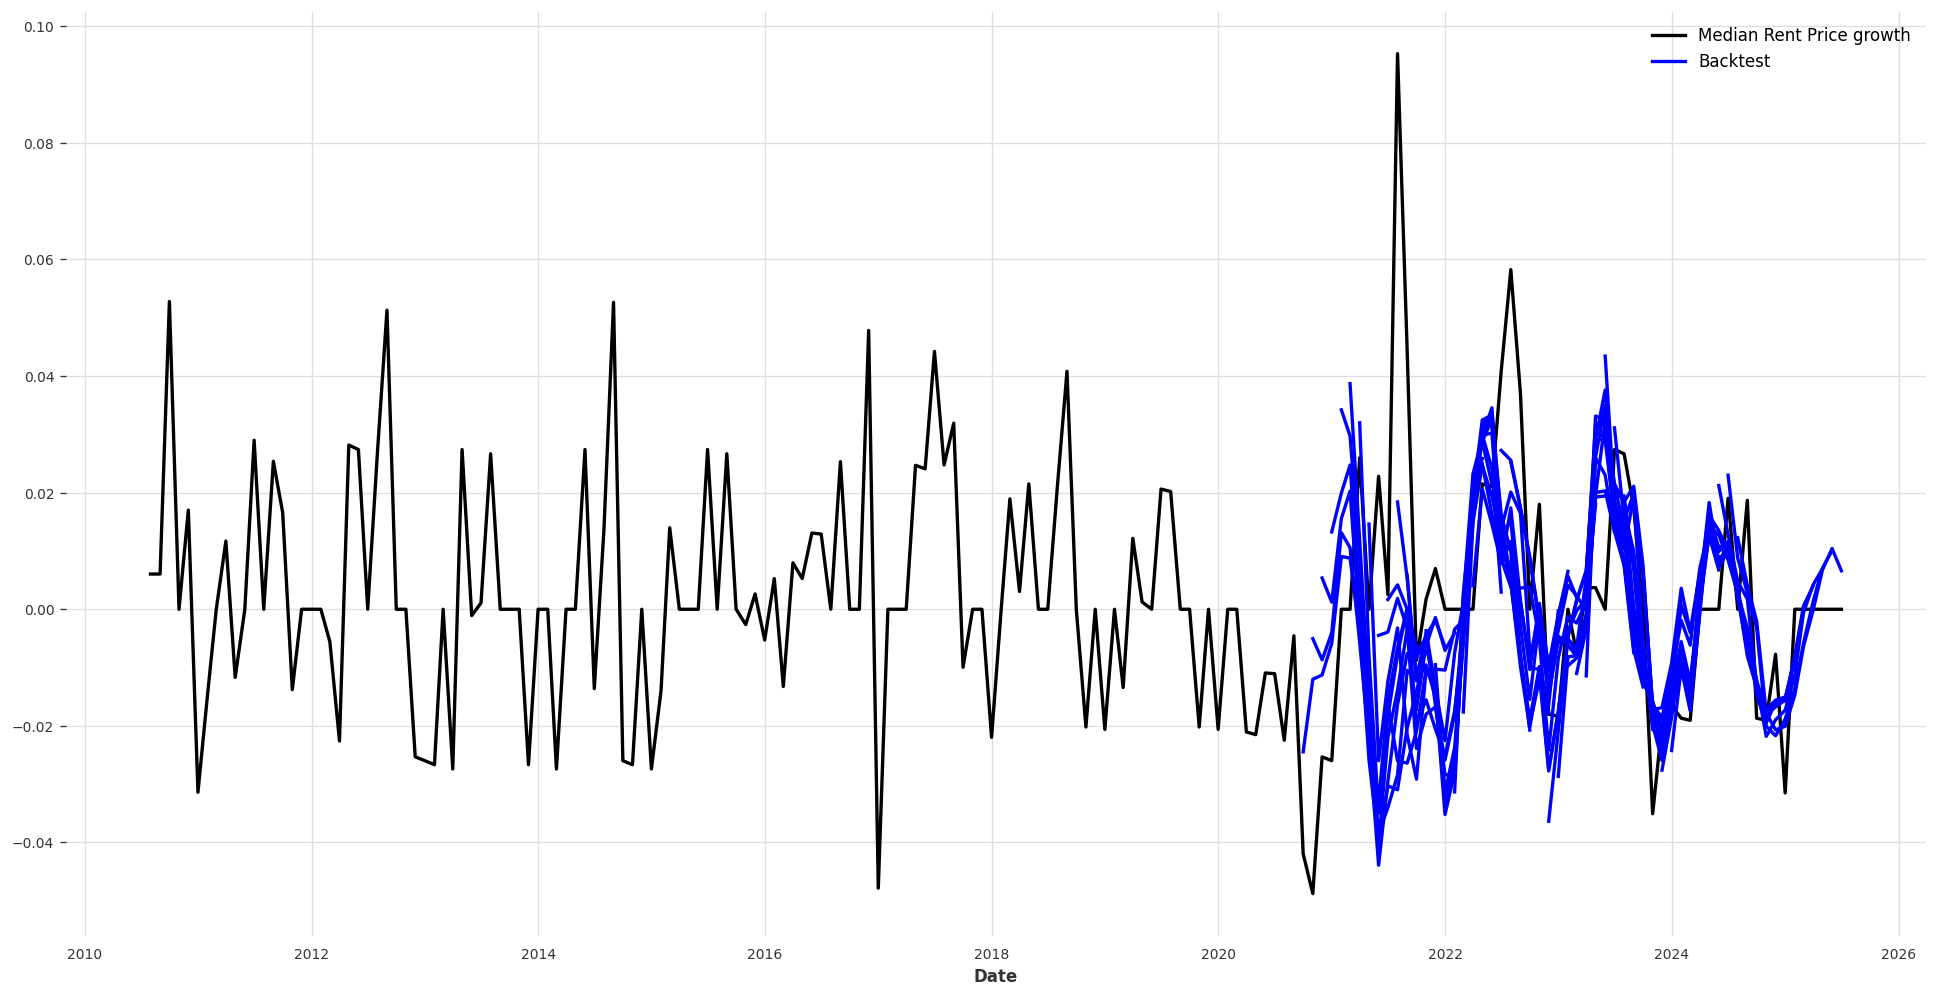

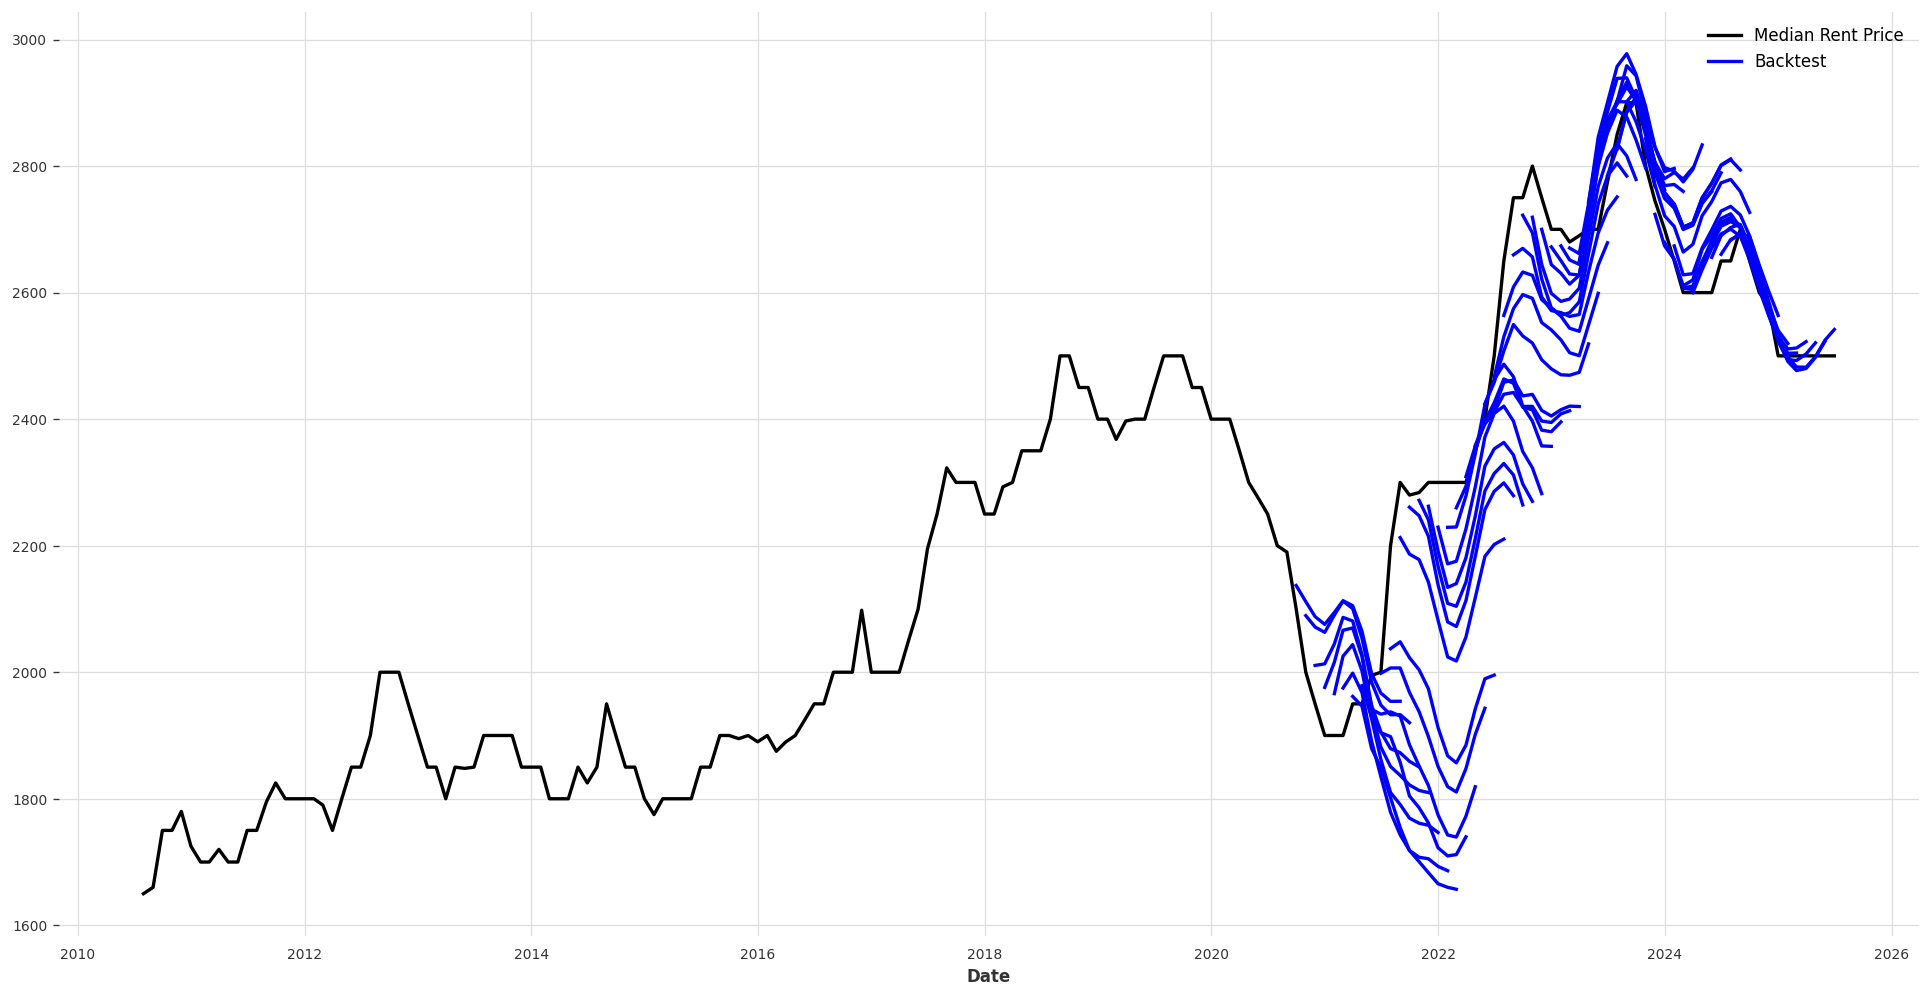

In [160]:
b = VAR.historical_forecasts(
    y,
    # future_covariates=cov,
    start=test_split_time,
    forecast_horizon=horizon,
    stride=1,
    last_points_only=False,  # True,
    retrain=False,
    overlap_end=False,
    verbose=False,
    enable_optimization=False,
)
eval_results(y, b, VAR, [rmse, mase], title="Backtest")
eval_results(
    y1,
    b,
    VAR,
    [rmse, mase],
    inverse_transform=True,
    title="Backtest",
)

/Users/andreypak/opt/miniconda3/envs/rent_app/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



component       Date  Median Rent Price  Unemployment rate diff  NHPI growth lag 3          LNLR Data Type
177       2025-04-30             2500.0                    -0.6          -0.004431  7.775181e-01    Actual
178       2025-05-31             2500.0                    -0.6           0.001775  7.349065e-01    Actual
179       2025-06-30             2500.0                    -0.6           0.001775  6.272013e-01    Actual
180       2025-07-31             2483.0                 10782.0        2486.000000  4.943000e+03  Forecast
181       2025-08-31             2460.0                 30936.0        2494.000000  8.787000e+03  Forecast
182       2025-09-30             2422.0                 51859.0        2503.000000  1.288000e+04  Forecast
183       2025-10-31             2386.0                 49345.0        2489.000000  2.227800e+04  Forecast
184       2025-11-30             2397.0                 55828.0        2493.000000  3.858800e+04  Forecast
185       2025-12-31             2360

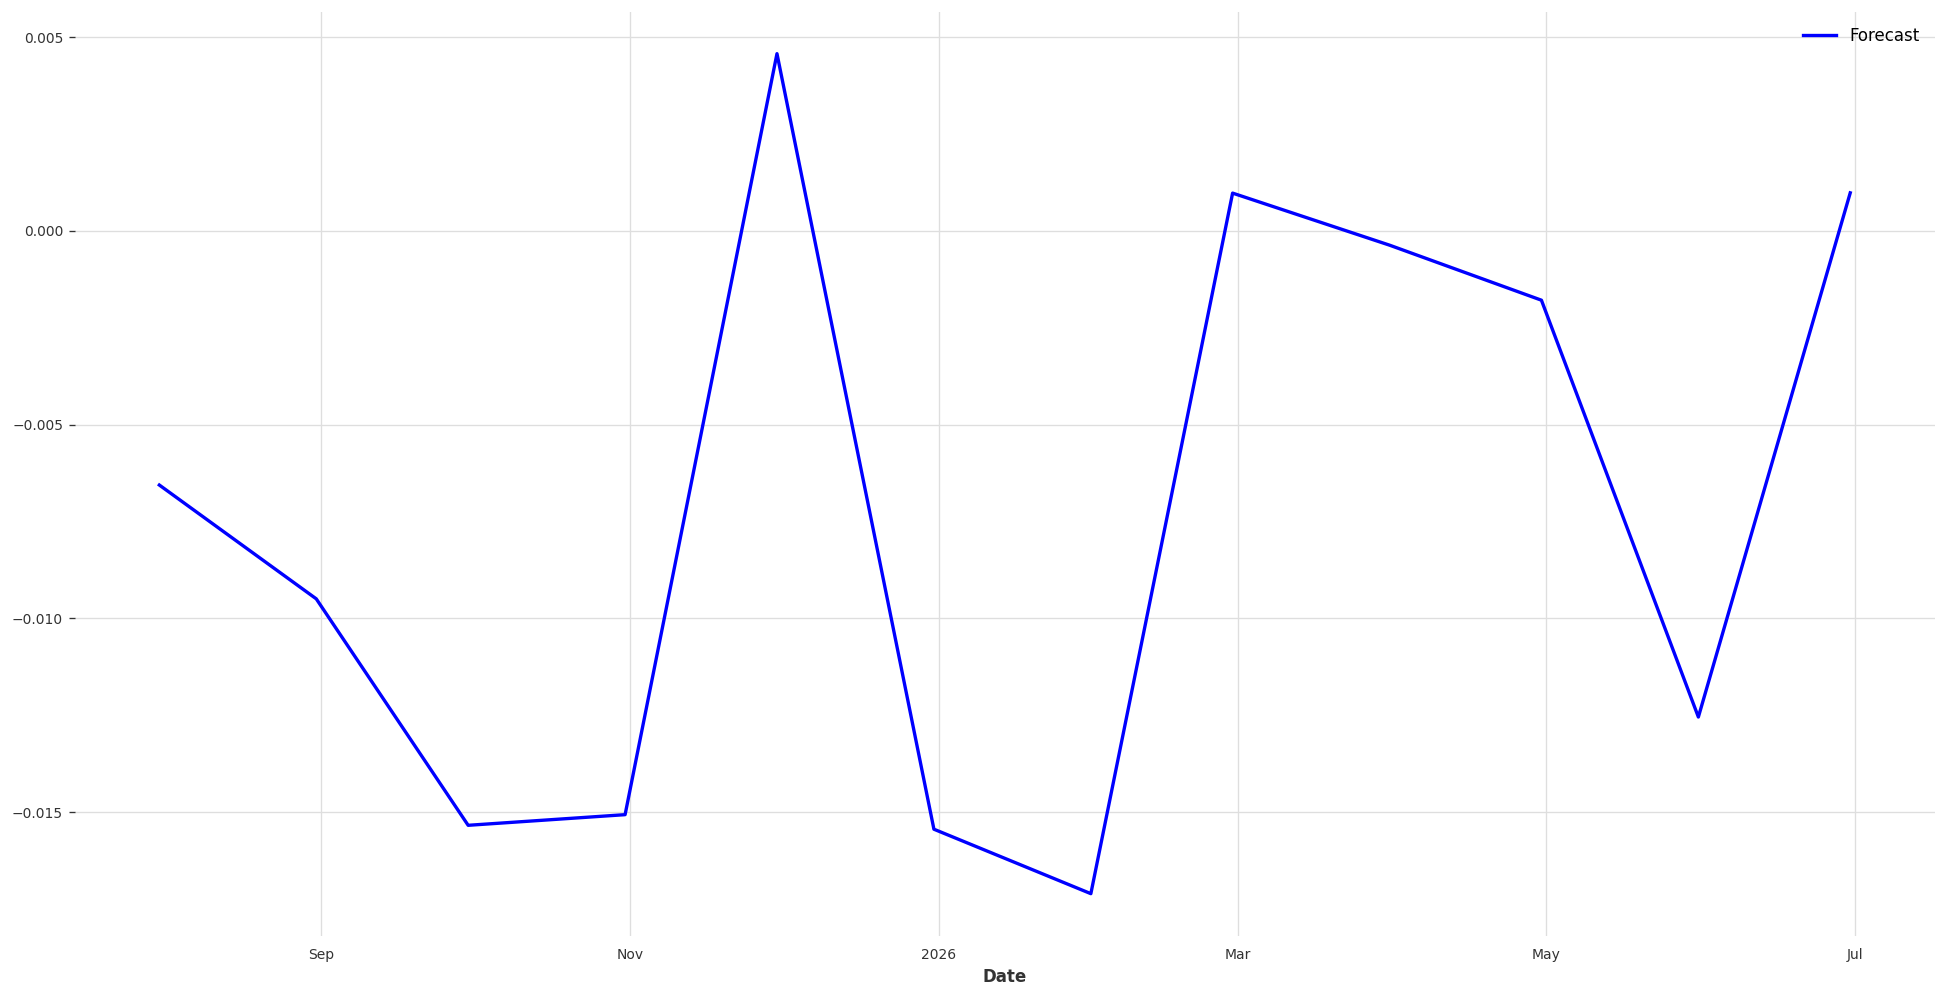

In [120]:
VAR.fit(y)

forecast = VAR.predict(12, y)
forecast[target].plot(label="Forecast", color="blue")
plot_forecast(
    convert_forecast(y1.pd_dataframe(), forecast.pd_dataframe()),
    target2,
).show()

## Residual Analysis

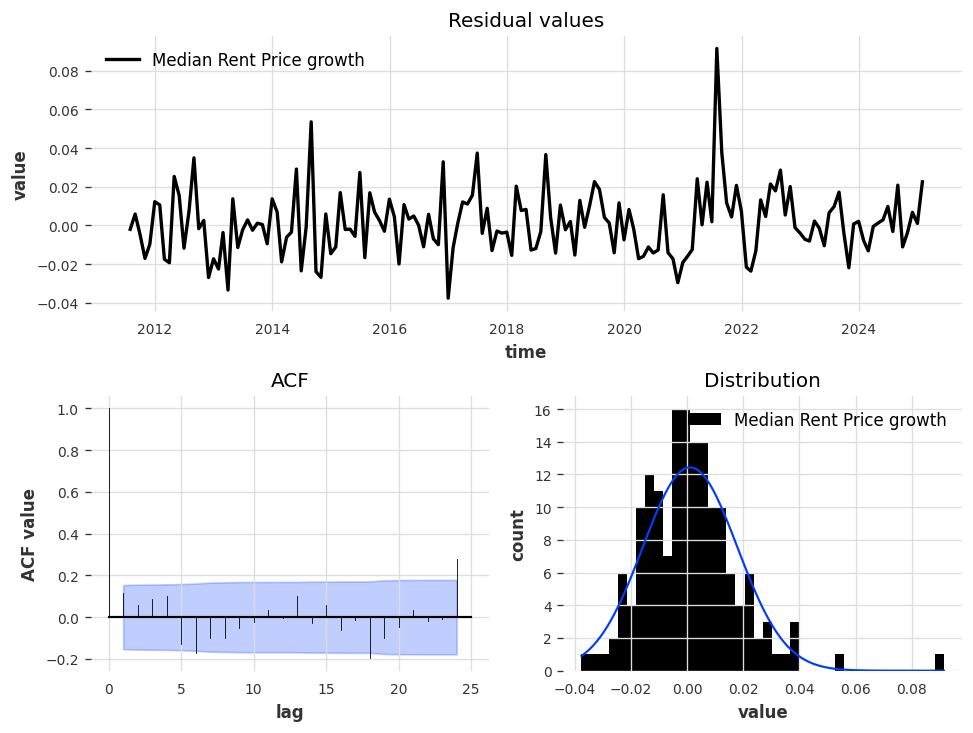

In [ ]:
residuals = LR.residuals(y, historical_forecasts=f)
plot_residuals_analysis(residuals, 40)

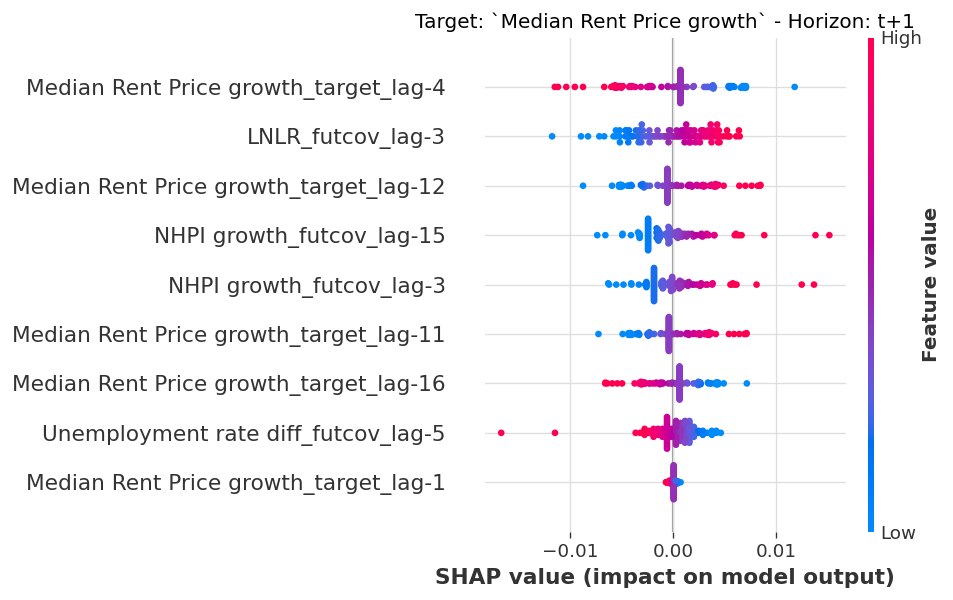

{1: {'Median Rent Price growth': .values =
  array([[ 6.15296791e-04, -3.14364836e-03,  4.43350095e-04,
          -2.00822206e-03, -3.64807850e-04, -1.30563909e-03,
           1.57774942e-03,  1.99643063e-03,  2.84842035e-03],
         [ 6.15296791e-04,  4.69897412e-04,  7.13586090e-03,
           3.42264249e-03,  4.42890419e-05,  3.21298115e-03,
          -3.65235915e-03,  5.80093435e-03,  1.10770207e-03],
         [ 6.15296791e-04,  8.48474291e-03, -4.21530696e-04,
           7.07210214e-04, -3.14025525e-04, -1.89707134e-04,
           1.57774942e-03,  3.83365958e-03,  5.47974907e-03],
         [ 2.64231278e-03, -5.65870196e-04,  2.01145709e-03,
          -6.02273384e-03, -1.89631030e-04, -1.31750321e-03,
           7.06064656e-04,  9.67580485e-04,  3.65464542e-03],
         [ 2.67279537e-03,  2.34783765e-03, -4.91408402e-03,
           7.07210214e-04,  2.38952191e-04, -1.98512281e-04,
           1.14190704e-03,  1.70070998e-05,  6.46916831e-03],
         [-2.11419180e-04, -5.9460812

In [ ]:
from darts.explainability.shap_explainer import ShapExplainer

shap_explain = ShapExplainer(LR)
shap_explain.summary_plot()

## Forecast

In [ ]:
LR.fit(y, future_covariates=cov)

forecast = LR.predict(3, y, future_covariates=cov)


FORECAST_PATH = "forecasts"
df_final = convert_forecast(y1.pd_dataframe(), forecast.pd_dataframe())
plot_forecast(df_final, target2).show()

component       Date  Median Rent Price Data Type
172       2024-07-31             2650.0    Actual
173       2024-08-31             2700.0    Actual
174       2024-09-30             2650.0    Actual
175       2024-10-31             2600.0    Actual
176       2024-11-30             2595.0    Actual
177       2024-12-31             2550.0    Actual
178       2025-01-31             2550.0    Actual
179       2025-02-28             2555.0  Forecast
180       2025-03-31             2552.0  Forecast
181       2025-04-30             2517.0  Forecast
